In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

def load_image(path):
    """Load an image and convert to RGB if necessary."""
    img = cv2.imread(path)
    if img is not None:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise FileNotFoundError(f"Could not load image from {path}")

def display_images(images, titles, cols=3, figsize=(15, 10)):
    """Display multiple images with titles in a grid."""
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 2.1 Linear transformations
def adjust_brightness(image, factor):
    """Adjust brightness of an image by adding a constant."""
    return np.clip(image.astype(np.float32) + factor, 0, 255).astype(np.uint8)

def stretch_contrast(image, min_percentile=1, max_percentile=99):
    """Apply contrast stretching to an image."""
    p_low, p_high = np.percentile(image, [min_percentile, max_percentile])
    if p_high == p_low:
        # Avoid division by zero
        return image.copy()
    stretched = (image - p_low) * 255.0 / (p_high - p_low)
    return np.clip(stretched, 0, 255).astype(np.uint8)


# 2.2 Image filtering
def mean_filter(image, kernel_size=3):
    """Apply mean filter to an image."""
    return cv2.blur(image, (kernel_size, kernel_size))

def gaussian_filter(image, kernel_size=3, sigma=1.0):
    """Apply Gaussian filter to an image."""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

# 2.3 Global thresholding
def global_threshold(image, threshold=127):
    """Apply global thresholding to an image."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    _, thresholded = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    return thresholded

# 2.4 Edge detection
def edge_detection(image, operator='sobel'):
    """Apply edge detection using Sobel or Prewitt operators."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    if operator.lower() == 'sobel':
        # Sobel operators
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        magnitude = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

    elif operator.lower() == 'prewitt':
        # Prewitt operators (using cv2.filter2D)
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

        prewitt_x = cv2.filter2D(gray, cv2.CV_64F, kernel_x)
        prewitt_y = cv2.filter2D(gray, cv2.CV_64F, kernel_y)

        magnitude = np.sqrt(np.square(prewitt_x) + np.square(prewitt_y))
    else:
        raise ValueError("Operator must be 'sobel' or 'prewitt'")

    # 🛡️ Safety check: replace NaNs and Infs
    magnitude = np.nan_to_num(magnitude, nan=0.0, posinf=255.0, neginf=0.0)

    # Normalize
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return magnitude.astype(np.uint8)


# 2.5 Histogram equalization
def histogram_equalization(image):
    """Apply histogram equalization to enhance contrast."""
    if len(image.shape) == 3:
        # For color images, apply to each channel
        result = np.zeros_like(image)
        for i in range(3):
            result[:, :, i] = cv2.equalizeHist(image[:, :, i])
        return result
    else:
        # For grayscale images
        return cv2.equalizeHist(image)

# 2.6 2D convolution with custom kernel
def apply_convolution(image, kernel):
    """Apply 2D convolution with a custom kernel."""
    return cv2.filter2D(image, -1, kernel)

def main():
    # Load image
    try:
        # Try loading from a URL (example)
        image_path = "tulips.png"  # Replace with your image path
        image = load_image(image_path)
        
        # Convert to grayscale for some operations
        grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Apply all transformations
        # 2.1 Linear transformations
        brightened = adjust_brightness(image, 50)
        darkened = adjust_brightness(image, -50)
        contrast_stretched = stretch_contrast(image, 5, 95)
        
        # 2.2 Image filtering
        mean_filtered = mean_filter(image, 5)
        gaussian_filtered = gaussian_filter(image, 5, 1.5)
        
        # 2.3 Global thresholding
        thresholded = global_threshold(image, 127)
        
        # 2.4 Edge detection
        sobel_edges = edge_detection(image, 'sobel')
        prewitt_edges = edge_detection(image, 'prewitt')
        
        # 2.5 Histogram equalization
        hist_equalized = histogram_equalization(image)
        
        # 2.6 2D convolution for sharpening
        sharpening_kernel = np.array([[-1, -1, -1],
                                      [-1,  9, -1],
                                      [-1, -1, -1]])
        sharpened = apply_convolution(image, sharpening_kernel)
        
        # Display results in groups
        # Group 1: Original and Linear Transformations
        display_images([image, brightened, darkened, contrast_stretched],
                      ["Original", "Brightened", "Darkened", "Contrast Stretched"])
        
        # Group 2: Filtering
        display_images([image, mean_filtered, gaussian_filtered],
                      ["Original", "Mean Filtered", "Gaussian Filtered"])
        
        # Group 3: Thresholding and Edge Detection
        display_images([grayscale, thresholded, sobel_edges, prewitt_edges],
                      ["Grayscale", "Thresholded", "Sobel Edges", "Prewitt Edges"])
        
        # Group 4: Histogram Equalization and Sharpening
        display_images([image, hist_equalized, sharpened],
                      ["Original", "Histogram Equalized", "Sharpened"])
        
    except Exception as e:
        print(f"Error: {e}")


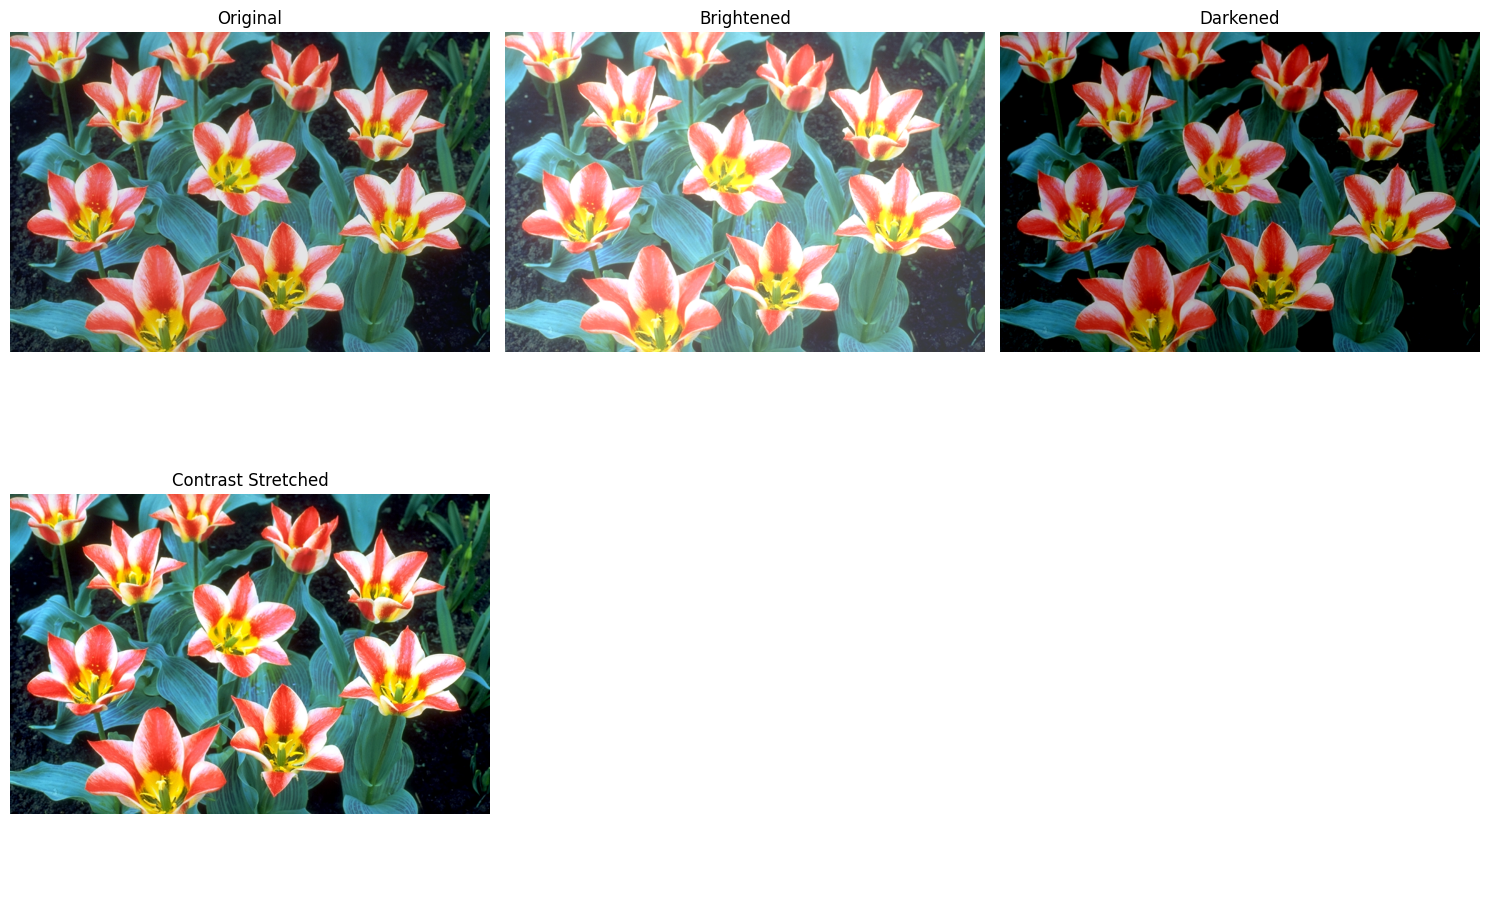

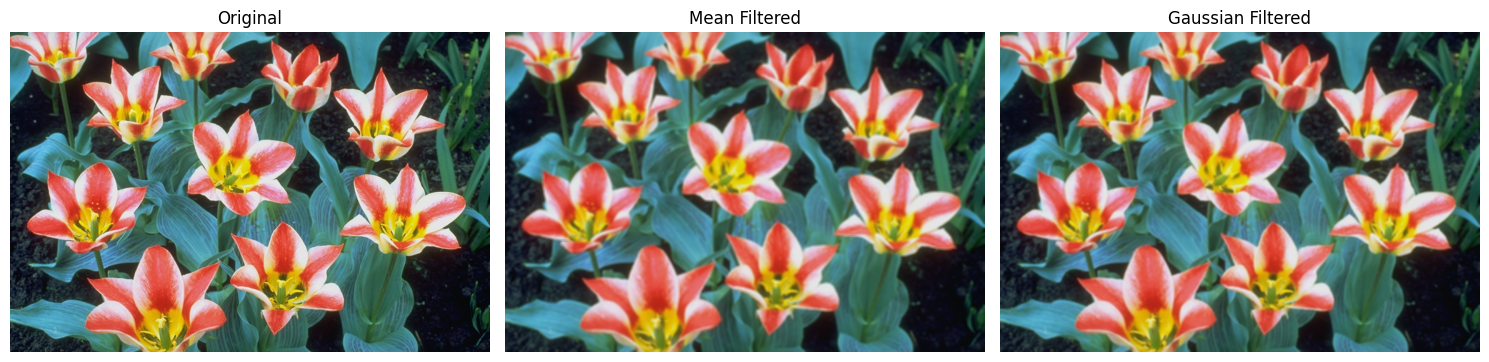

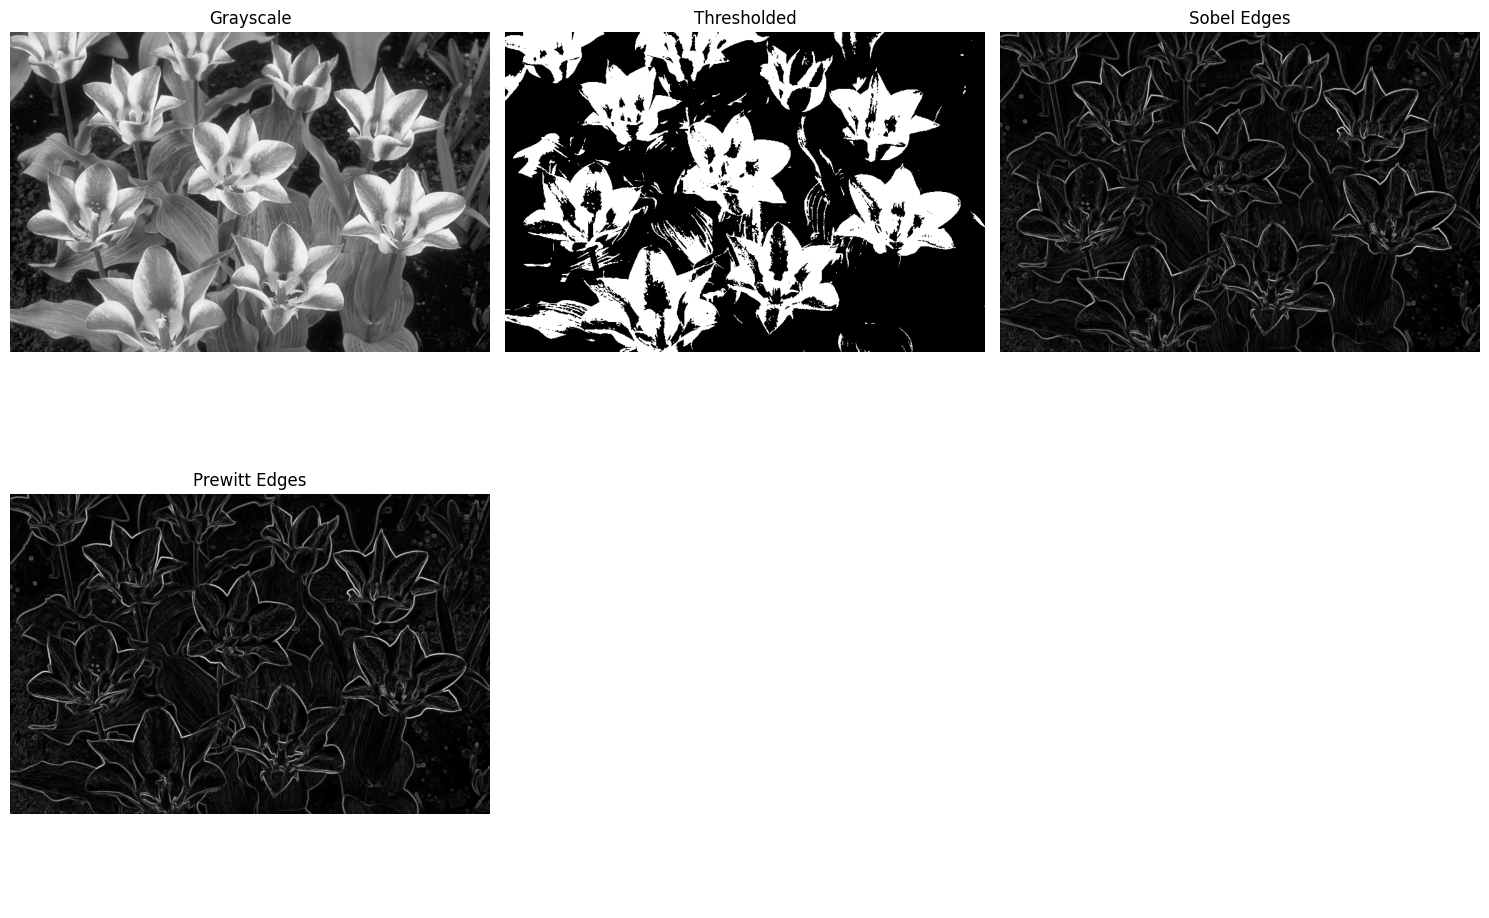

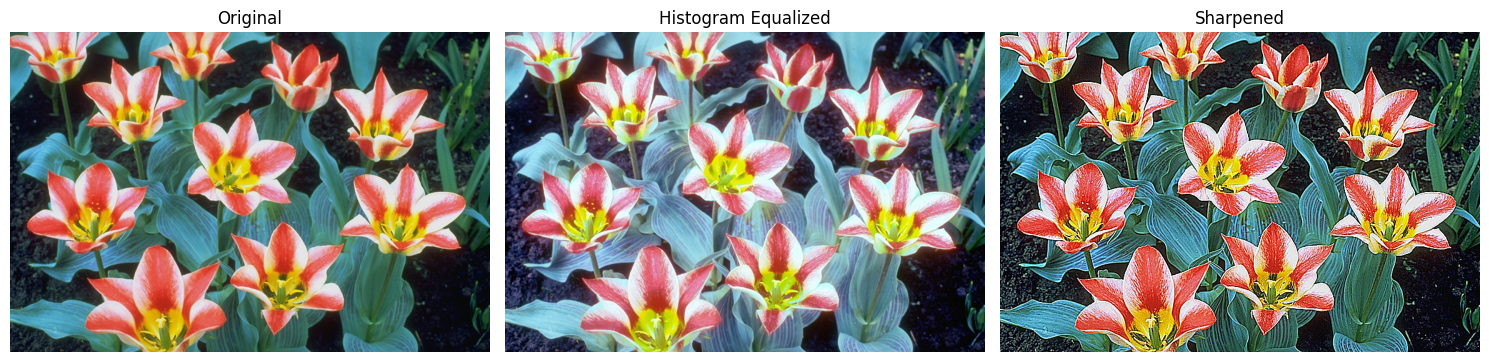

In [10]:
main()